In [1]:
import os
os.chdir('/content/drive/MyDrive/Maciej_Zielonka_Senior_Project/Maciej_Zielonka_CPSC_490/src')

# Part 0: Requirements 
Make sure requirements are installed

In [2]:
!chmod +x requirements.txt

In [ ]:
!./requirements.txt

# Part 1: Training an audio-based engagement model

## 1A. Prepare the data
Given ELAN annotations, extract desired sections of `.wav` files and save them as numpy arrays, which will then be used to train a classifier

In [4]:
# These are the directories where we will store data for later use

eaf_dir = "../ELAN_Annotations"
audio_dir = "../Interview_data"
json_dir = "../Annotations_as_json"
csv_dir = "../wav_chunk_csvs"

In [5]:
from elan_to_classifier import *
from feature_extractors import *

In [ ]:
# For each `.eaf` file, store the start and end of the time slots as keys, and the binary
# annotation of 0 or 1 as the values

annotations_to_json(eaf_dir, json_dir)

In [ ]:
# Now that each `.wav` file has dictionaries stored as jsons, we can extract only the 
# sections that those dictionaries correspond to. At the end of this, we will have a
# `.csv` file for every relevant chunk, where the last entry will correspond to the engagement
# annotation

save_all_chunks_with_labels(audio_dir, json_dir, csv_dir)

In [ ]:
from feature_extractors import *

# Create numpy arrays for all the features, and the labels
features_df = create_all_features_df(csv_dir)

In [ ]:
features_df.to_csv("features_df.csv")

## 1B. Build the Engagement Model

In model_determination.ipynb, we discovered that the Random Forest Classifier performs the best. Here we build a model and save it. 

In [5]:
import pandas as pd

features_df = pd.read_csv("features_df.csv")
features = features_df.drop(['Unnamed: 0', 'Engaged'], axis=1)
labels = features_df['Engaged']
X = features.values
y = labels.values

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn import svm
from sklearn import tree
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report,confusion_matrix
from itertools import product
from sklearn.model_selection import train_test_split

def clf_accuracy(clf, clf_name, x_test, y_test):
  y_pred = clf.predict(x_test)
  disp = metrics.plot_confusion_matrix(clf, x_test, y_test,
                                  display_labels=[0,1],
                                  cmap=plt.cm.Blues)

  print(disp.confusion_matrix)
  print("Accuracy of", clf_name, ":", metrics.accuracy_score(y_test, y_pred))
  print(classification_report(y_test, y_pred))


In [7]:
def run_random_forest(features_array, labels_array):
  x_train, x_test, y_train, y_test = train_test_split(features_array, labels_array, test_size=0.3, stratify=labels_array)
  clf = RandomForestClassifier()
  clf.fit(x_train, y_train)
  clf_accuracy(clf, "Random Forest", x_test, y_test)
  return clf

[[38  9]
 [ 6 48]]
Accuracy of Random Forest : 0.8514851485148515
              precision    recall  f1-score   support

         0.0       0.86      0.81      0.84        47
         1.0       0.84      0.89      0.86        54

    accuracy                           0.85       101
   macro avg       0.85      0.85      0.85       101
weighted avg       0.85      0.85      0.85       101



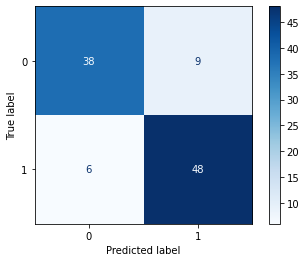

In [10]:
# Run a random forest classifier and observe the results
random_forest_clf = run_random_forest(X, y)

In [11]:
# Save the model
import pickle

pickle.dump(random_forest_clf, open("random_forest_clf", 'wb'))

In [12]:
# Load the saved model
import pickle

random_forest_clf = pickle.load(open("random_forest_clf", 'rb'))

# Part 2: Diarization

In order to classify social contingency, we must be able to distinguish between speaking individuals, as well as when there is silence or extra noise. This part will demonstrate how diarization is approached for this project

## 2A. Create partial embeddings for each audio segment
### Embeddings are created using Resemblyzer's VoiceEncoder. For more info and for the repo, check out [Resemblyzer](https://github.com/resemble-ai/Resemblyzer)

An example follows, using an interview from the dataset

In [13]:
from speaker_diarization import *

In [14]:
import librosa
wav_file = "../Interview_data/P5_S1.wav"
y, sr = librosa.load(wav_file)

In [15]:
# Generate the partial embeddings and the list of wav_splits

embeddings, wav_splits = generate_embeddings(y)

Loaded the voice encoder model on cpu in 0.02 seconds.


## 2B. Cluster the embeddings

### For this project, [scikit learn's spectral clustering](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.SpectralClustering.html) was used to cluster the embeddings

In [16]:
# Create spectral clustering predictions for the embeddings
labels = spectral_cluster_predict(embeddings, n_clusters=3)

[0 1 2]


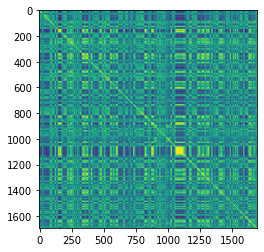

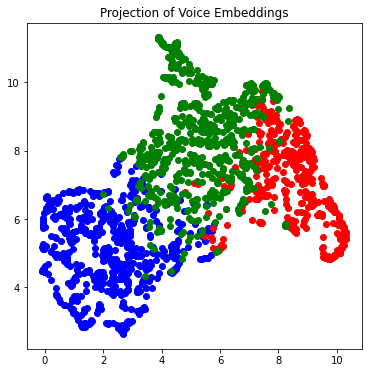

In [17]:
# Visualize the embeddings:

show_plots(embeddings, labels)

Clearly, there are regions of similarity, and speech can be divided into three clusters (two speakers, one silent cluster)

## 2C. Create the labellings for the wav segment

In [18]:
diarization_dict, labelling = label_wav_splits(y, wav_splits, labels)

In [19]:
# Create a diarization transcript for this audio
# Due to the limitations of using Google Colab, I couldn't seem to play this 
# file, but it does follow the breakdown pretty closely
print_diarization(labelling)

# from pydub import AudioSegment
# from pydub.playback import play

# sound = AudioSegment.from_file(wav_file, 'wav', frame_rate=sr)
# play(sound)

0:0.0 - 0:5.5 -- Adult
0:5.5 - 0:6.4 -- Silence
0:6.4 - 0:6.6 -- Child
0:6.6 - 0:15.8 -- Adult
0:15.8 - 0:16.2 -- Child
0:16.2 - 0:16.7 -- Silence
0:16.7 - 0:17.5 -- Adult
0:17.5 - 0:19.3 -- Child
0:19.3 - 0:22.5 -- Adult
0:22.5 - 0:23.1 -- Child
0:23.1 - 0:24.2 -- Silence
0:24.2 - 0:25.1 -- Child
0:25.1 - 0:26.7 -- Adult
0:26.7 - 0:27.4 -- Child
0:27.4 - 0:32.1 -- Silence
0:32.1 - 0:34.7 -- Child
0:34.7 - 0:39.9 -- Adult
0:39.9 - 0:44.7 -- Child
0:44.7 - 0:45.4 -- Silence
0:45.4 - 0:46.7 -- Child
0:46.7 - 0:46.8 -- Silence
0:46.8 - 0:47.6 -- Child
0:47.6 - 0:47.7 -- Adult
0:47.7 - 0:50.1 -- Child
0:50.1 - 0:51.9 -- Adult
0:51.9 - 0:52.3 -- Child
0:52.3 - 0:52.6 -- Silence
0:52.6 - 0:54.5 -- Adult
0:54.5 - 0:55.5 -- Silence
0:55.5 - 0:56.1 -- Child
0:56.1 - 0:57.7 -- Adult
0:57.7 - 0:57.9 -- Child
0:57.9 - 1:0.8 -- Adult
1:0.8 - 1:3.5 -- Silence
1:3.5 - 1:3.7 -- Child
1:3.7 - 1:4.1 -- Silence
1:4.1 - 1:4.4 -- Child
1:4.4 - 1:4.8 -- Silence
1:4.8 - 1:8.4 -- Child
1:8.4 - 1:9.5 -- Silenc

The above technique creates partial embeddings for the entire interview, then clusters the embeddings into three segments: Adult, Child, and Silent. But it might be better to try to embed the speakers alone, and take out the silence initially. Here, [pydub's silence library](https://https://github.com/jiaaro/pydub/blob/master/pydub/silence.py) was used to initially extract all the speech, without any of the silence, and just create the clusters: Adult, Child

Loaded the voice encoder model on cpu in 0.31 seconds.
[0 1]


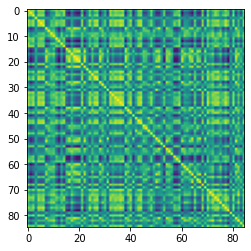

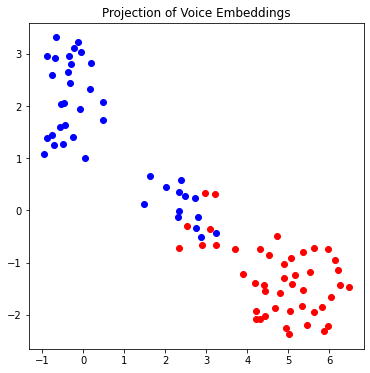

In [20]:
labelling, silent_segments = diarize_with_pydub(wav_file, 500, -50)

We see the embeddings are much more distinct, and although the final diarization is similar to the original, non-pydub using one, there is less noise splitting up the two. It is up to the user to decide which technique to use.

In [21]:
print_diarization(labelling)

0:0.0 - 0:3.1 -- Adult
0:3.1 - 0:3.6 -- Silence
0:3.6 - 0:5.3 -- Adult
0:5.3 - 0:6.4 -- Silence
0:6.4 - 0:16.0 -- Adult
0:16.0 - 0:16.7 -- Silence
0:16.7 - 0:17.3 -- Child
0:17.3 - 0:17.9 -- Silence
0:17.9 - 0:23.0 -- Adult
0:23.0 - 0:24.1 -- Silence
0:24.1 - 0:26.8 -- Adult
0:26.8 - 0:32.2 -- Silence
0:32.2 - 0:39.9 -- Adult
0:39.9 - 0:40.7 -- Silence
0:40.7 - 0:41.1 -- Child
0:41.1 - 0:41.7 -- Silence
0:41.7 - 0:42.5 -- Child
0:42.5 - 0:43.1 -- Silence
0:43.1 - 0:44.6 -- Adult
0:44.6 - 0:45.4 -- Silence
0:45.4 - 0:49.5 -- Child
0:49.5 - 0:50.0 -- Silence
0:50.0 - 0:52.3 -- Adult
0:52.3 - 0:53.0 -- Silence
0:53.0 - 0:54.2 -- Adult
0:54.2 - 0:55.0 -- Silence
0:55.0 - 0:57.0 -- Adult
0:57.0 - 0:57.6 -- Silence
0:57.6 - 1:0.6 -- Adult
1:0.6 - 1:1.3 -- Silence
1:1.3 - 1:2.7 -- Child
1:2.7 - 1:3.8 -- Silence
1:3.8 - 1:3.9 -- Child
1:3.9 - 1:4.6 -- Silence
1:4.6 - 1:6.2 -- Child
1:6.2 - 1:6.7 -- Silence
1:6.7 - 1:7.2 -- Child
1:7.2 - 1:7.8 -- Silence
1:7.8 - 1:8.0 -- Child
1:8.0 - 1:9.1 -- 

# Part 3: Determine Social Contingency of an Interaction


## 3A. Extract Structural Features From the Data

When determining social contingency, we will be looking at silence within the conversation, how often each agent speaks in the conversation, and the engagement present in the responses. So let's extract that information



In [22]:
from structural_feature_extractors import *

In [ ]:
silent_periods, silent_period_lengths, engagement_tracker = extract_structural_features_from_diarized_interview(y, labelling, random_forest_clf)

Here we'll extract structural features that may indicate the presence, or the lack of social contingency in a conversation. 

In [24]:
import pandas as pd

def analyze_contingency(id, silent_periods, silent_period_lengths, engagement_tracker, sr=22050):
    """
    Create a dataframe of all the features that could be relevant to determining social contingency
    id - The id for the dataframe
    silent_periods - A list of tuples containing (`silent_segment_start_frame`, `silent_segment_end_frame`)
        Lists the start and end frames of each silent segment in a wave file
    silent_period_lengths - A list of the lengths of the silent segments in a wave file. Useful for easier computation and averages
    engagement_tracker - A list of "engagement markers" for segments of the interview. If the segment contained a child's response, 1 if engaged, 0 if disengaged. 
        If the segment contained the adult's voice, mark a -1 for the lack of a response from the child. 

    The dataframe has the columns:
    id - wave file id
    Avg Silence - The average duration of silence present in the conversation
    Std Silence - The standard deviation of the durations of silence
    Silence Slope - The slope of the durations of silence as found by linear regression
    Engaged - The number of child responses determined to be engaged by the classifier
    Disengaged - The number of disengaged responses
    No Answers - The number of times there was no response from the child, and the adult spoke twice in a row
    SBE - (Silence Before Engaged) The average duration of silence present before an engaged response
    SBD - (Silence Before Disengaged) The average duration of silence present before a disengaged response
    SBNA - (Silence Before No Answer) The average duration of silence present before a no-response
    Conf Eng - (Confidence of Engagement) How confident the model is in its prediction of Engagement
    Conf Diseg - (Confidence of Disengagement) How confident the model is in its prediction of Disengagement
    """
    attributes = {}
    sum_silence = sum(silent_period_lengths)
    avg_silence = np.mean(silent_period_lengths)
    std_silence = np.std(silent_period_lengths)
    attributes['id'] = id
    attributes['Avg Silence'] = avg_silence/sr
    attributes['Std Silence'] = std_silence/sr
    slope = find_silence_slope(silent_period_lengths)
    attributes['Silence Slope'] = slope 
    engagement_count = [0, 0, 0]
    for marker in engagement_tracker:
        if type(marker) is tuple:
            val = marker[0]
        elif marker > 1:
            continue
        else:
            val = marker
        engagement_count[val + 1] += 1
    print(engagement_count)
    num_engaged = engagement_count[2]
    num_disengaged = engagement_count[1]
    num_no_answer = engagement_count[0]
    attributes['Engaged'] = num_engaged
    attributes['Disengaged'] = num_disengaged
    attributes['No Answers'] = num_no_answer
    sbna, sbd, sbe, conf_diseng, conf_eng, conf_df = find_total_silence_before_marker(engagement_tracker)
    attributes['SBE'] = sbe/num_engaged / sr if num_engaged > 0 else 0
    attributes['SBD'] = sbd / num_disengaged / sr if num_disengaged > 0 else 0
    attributes['SBNA'] = sbna / num_no_answer / sr if num_no_answer > 0 else 0
    attributes['Conf Eng'] = conf_eng / num_engaged if num_engaged > 0 else 0
    attributes['Conf Diseng'] = conf_diseng / num_disengaged if num_disengaged > 0 else 0
    attributes_df = pd.DataFrame(attributes, index=[1])
    file_name = "../confidence_dfs/" + id + ".csv"
    conf_df.to_csv(file_name)
    return attributes_df

def find_total_silence_before_marker(engagement_tracker):
    """
    Finds the duration of silence before each marker, whether that's engaged, disengaged, or no answer
    """
    total_silence_before_marker = [0, 0, 0]
    engagement_confidence = [0, 0]
    confidence_vals = []
    for i in range(1, len(engagement_tracker)):
        val = engagement_tracker[i]
        pre_engagement_marker = engagement_tracker[i-1]
        if type(pre_engagement_marker) is tuple or pre_engagement_marker == -1:
            continue
        if not type(val) is tuple and val != -1:
            continue
        if type(val) is tuple:
            engagement_marker = val[0]
            conf = val[1]
            confidence_vals.append([engagement_marker, conf, pre_engagement_marker])
            engagement_confidence[engagement_marker] += conf
        else:
            engagement_marker = val
        total_silence_before_marker[engagement_marker + 1] += pre_engagement_marker
    conf_df = pd.DataFrame(confidence_vals)
    conf_df.columns = ['Engagement_Marker', 'Confidence', 'Silence_Before']
    return total_silence_before_marker[0], total_silence_before_marker[1], total_silence_before_marker[2], engagement_confidence[0], engagement_confidence[1], conf_df


[[0.00040909]]


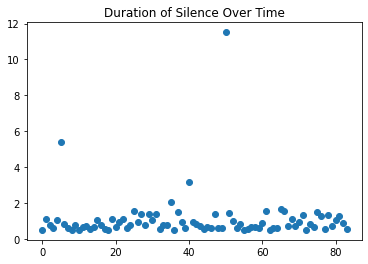

[26, 37, 3]


In [25]:
contingency_df = analyze_contingency("P5_S1", silent_periods, silent_period_lengths, engagement_tracker)

In [26]:
contingency_df

,id,Avg Silence,Std Silence,Silence Slope,Engaged,Disengaged,No Answers,SBE,SBD,SBNA,Conf Eng,Conf Diseng
1,P5_S1,1.087678,1.315407,0.000409,3,37,26,0.896327,1.269949,1.058149,0.553333,0.723514


# Putting It All Together


This section contains a runnable example of everything above. Just load the model, pick the audio file you want to analyze, and run

In [8]:
import librosa
from helpers import path_leaf
from speaker_diarization import *
from structural_feature_extractors import *

def extract_social_contingency_df_for_wav(audio_path, clf):
    print(audio_path)
    y, sr = librosa.load(audio_path)
    labelling = diarize_with_pydub(audio_path, 500)[0]
    print_diarization(labelling)
    id = path_leaf(audio_path)[:-4]
    silent_periods, silent_period_lengths, engagement_tracker = extract_structural_features_from_diarized_interview(y, labelling, clf)
    df = analyze_contingency(id, silent_periods, silent_period_lengths, engagement_tracker, sr)
    return df

In [9]:
# Create a list of paths to all the interviews
# Note: Some of them error out when trying to load certain spectral features
# Online, it says that that's the fault of the audio. Couldn't find anything more specific
import os

all_interviews = [os.path.join(audio_dir, f) for f in os.listdir(audio_dir)]

In [10]:
import pickle

random_forest_clf = pickle.load(open("random_forest_clf", 'rb'))

In [ ]:
audio_path = all_interviews[1]
df = extract_social_contingency_df_for_wav(audio_path, random_forest_clf)

In [10]:
# Look at the contingency dataframe for this example
df

,id,Avg Silence,Std Silence,Silence Slope,Engaged,Disengaged,No Answers,SBE,SBD,SBNA,Conf Eng,Conf Diseng
1,P14_S1,1.158254,0.625382,0.000925,94,3,18,1.20134,1.077672,1.193333,0.700532,0.536667


# Create a data frame of the contingency values of all of the files


In [11]:
all_dfs = []

In [ ]:
# Loop through the files, running the algorithm for them all, and storing the results
# Create a checkpoint at every fifth file, as well as at every error
# Only did 30 because it kept crashing
for i, interview in enumerate(all_interviews[:30]):
    print("Extracting dataframe for", interview)
    try:
        sc_df = extract_social_contingency_df_for_wav(interview, random_forest_clf)
        all_dfs.append(sc_df)
        if i % 5 == 0:
            check_point_df = pd.concat(all_dfs)
            file_name = "./checkpoint_" + str(i) + ".csv"
            check_point_df.to_csv(file_name)
        
    except:
        if all_dfs:
            check_point_df = pd.concat(all_dfs)
            file_name = "./checkpoint_" + str(i) + ".csv"
            check_point_df.to_csv(file_name)
        continue

In [ ]:
check_point_df = pd.concat(all_dfs)
file_name = "./final_checkpoint.csv"
check_point_df.to_csv(file_name)

# Visualization of results
Can we make any distinctions of social contingency based on the results?

In [27]:
import pandas as pd

contingency_df = pd.read_csv("./checkpoint_26.csv")
values = contingency_df.drop(['id', 'Unnamed: 0'], axis=1)

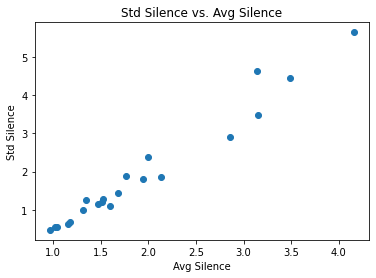

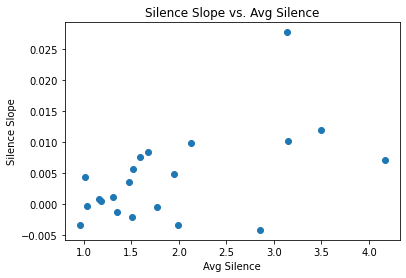

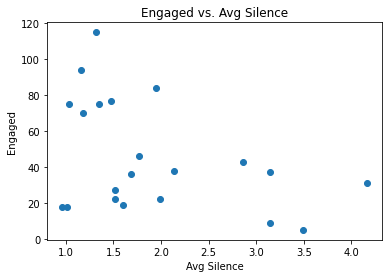

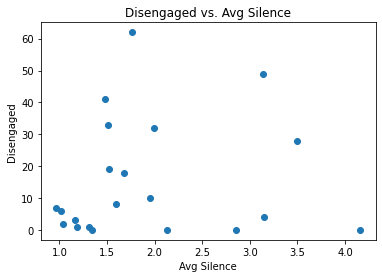

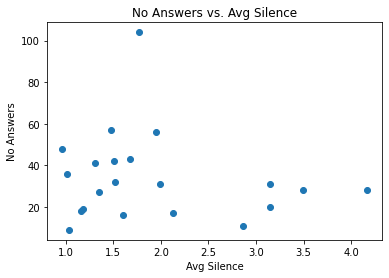

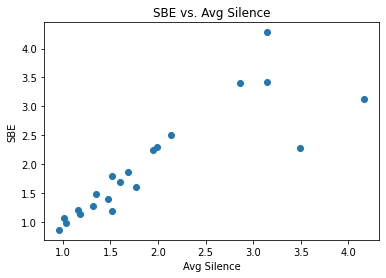

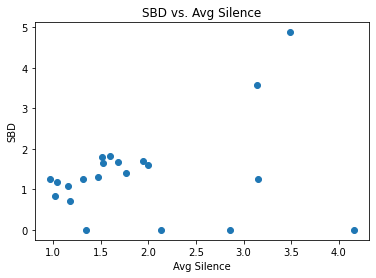

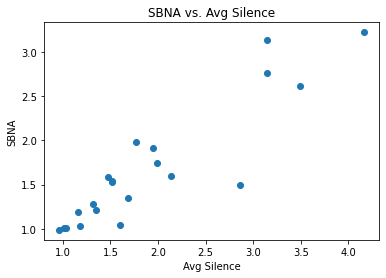

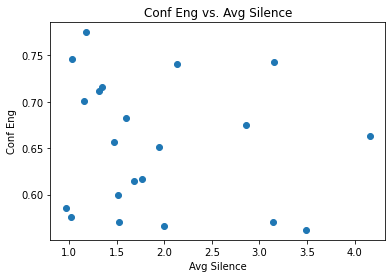

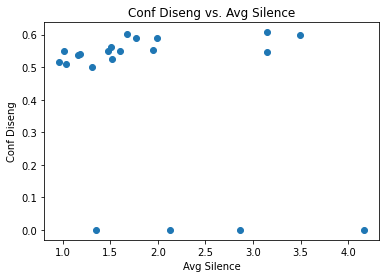

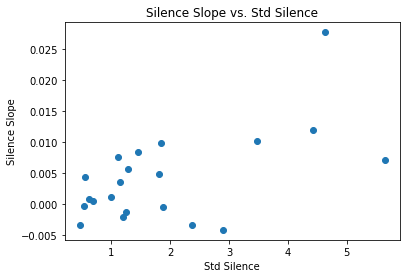

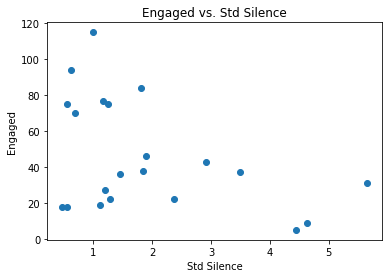

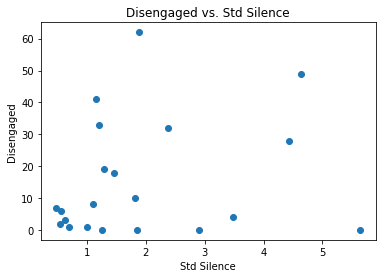

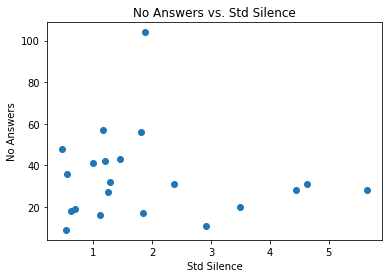

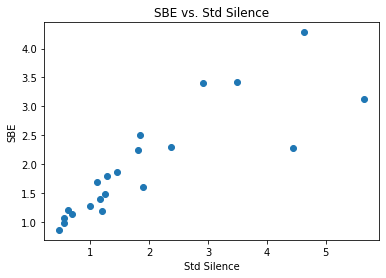

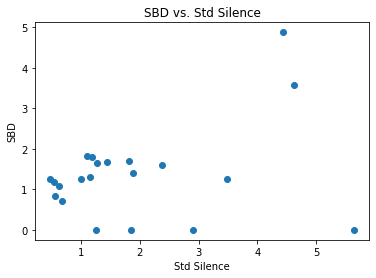

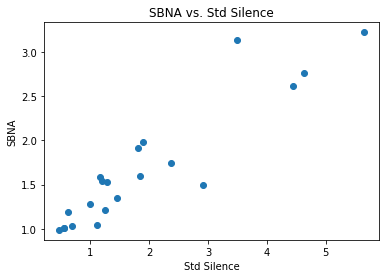

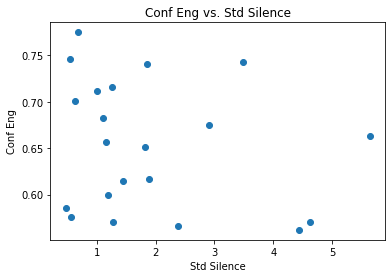

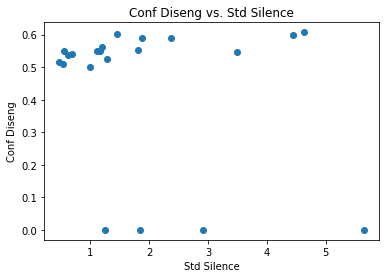

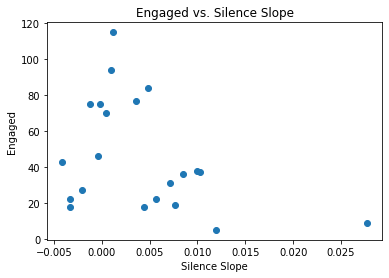

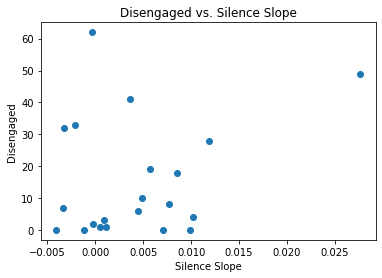

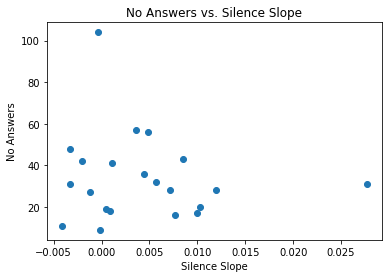

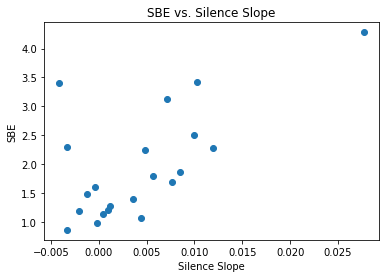

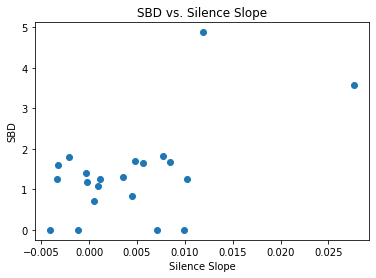

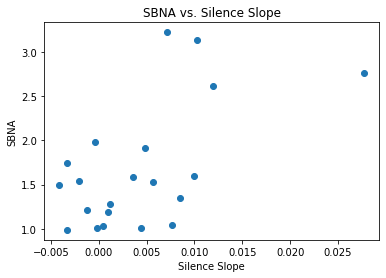

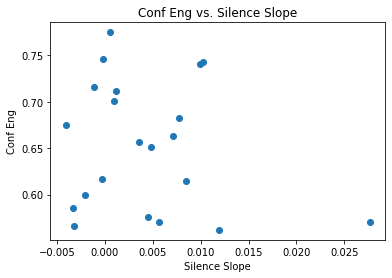

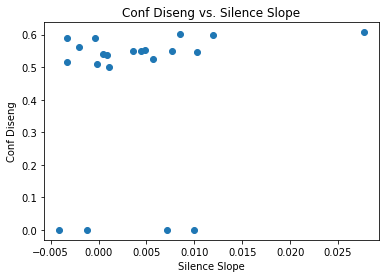

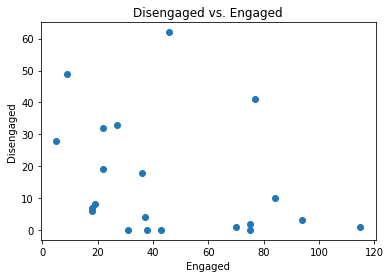

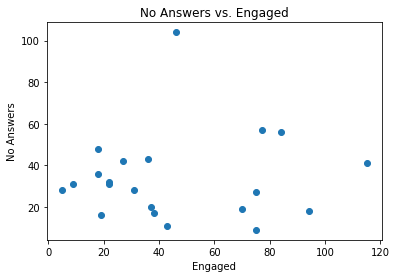

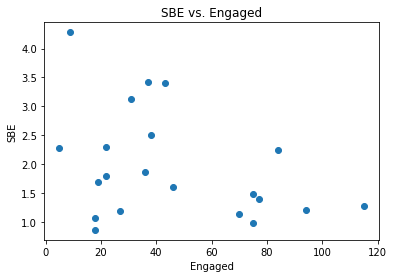

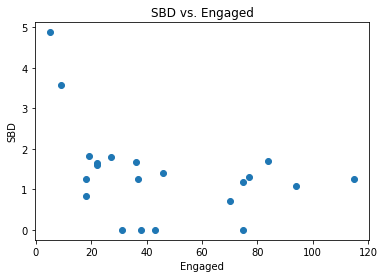

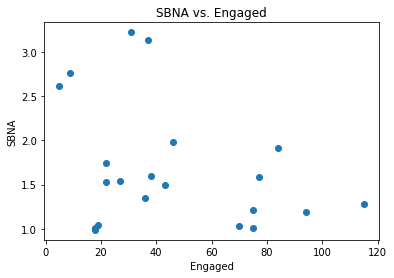

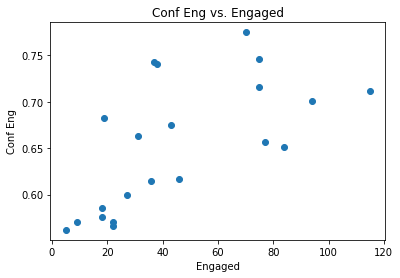

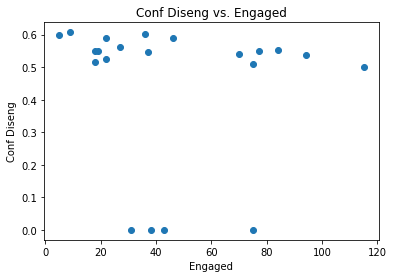

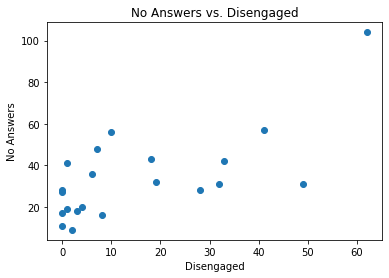

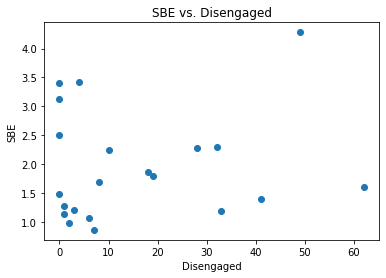

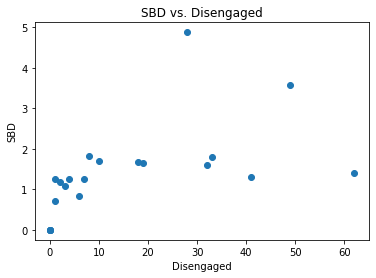

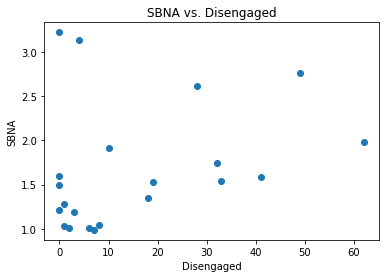

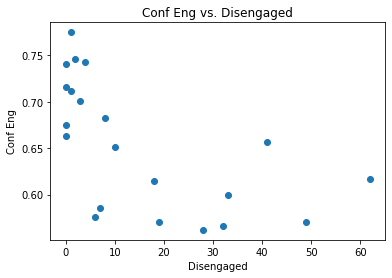

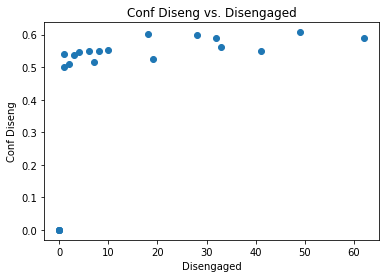

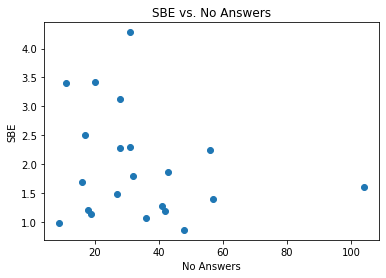

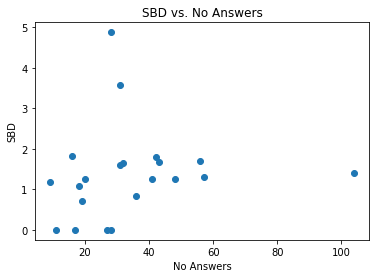

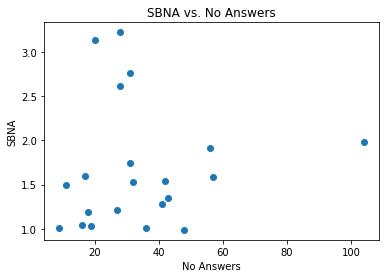

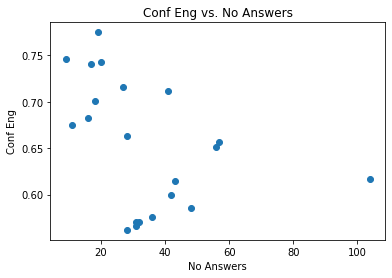

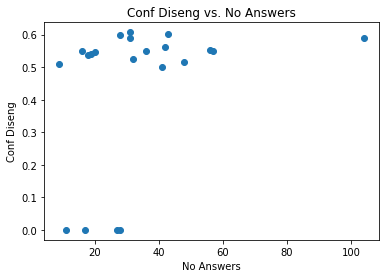

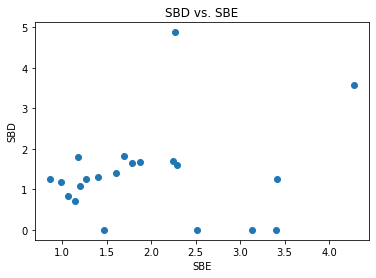

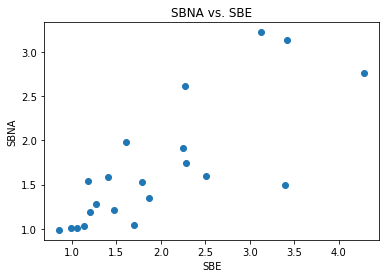

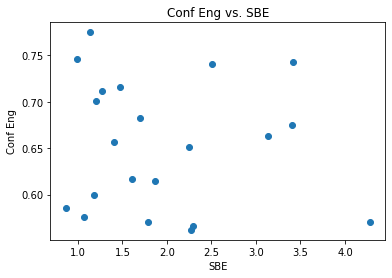

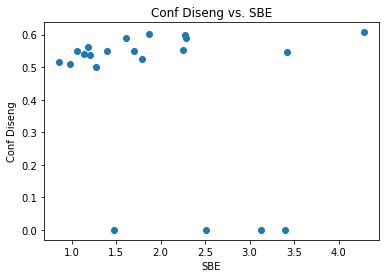

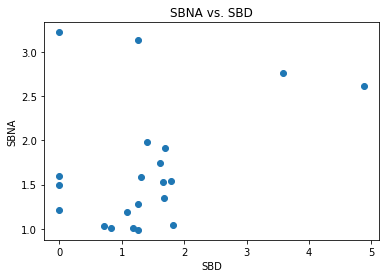

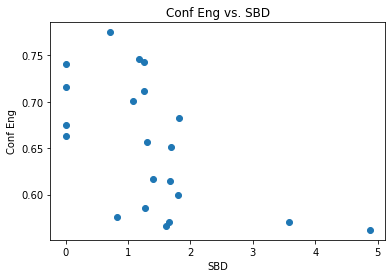

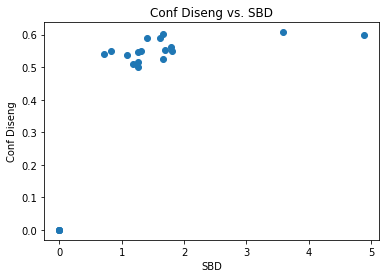

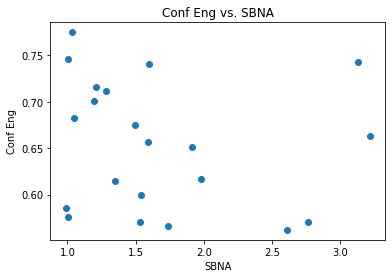

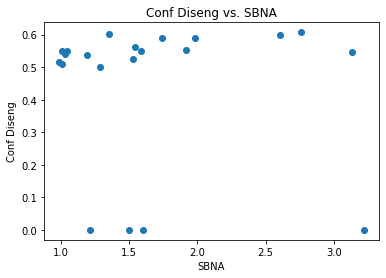

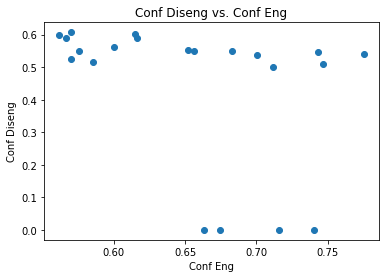

In [28]:
# Plot all values against each other to see if any clusters
# or any noticeable relationships form

import matplotlib.pyplot as plt

cols = values.columns
for i in range(len(cols) - 1):
    for j in range(i+1, len(cols)):
        plt.scatter(values[cols[i]].values, values[cols[j]].values)
        t = cols[j] + " vs. " + cols[i]
        plt.title(t)
        plt.xlabel(cols[i])
        plt.ylabel(cols[j])
        plt.show()

A lot of these results aren't too interesting, but some of them are:

In [30]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats

def graph_dfs(values, x_col, y_col):
    x = values[x_col].values
    y = values[y_col].values
    plt.scatter(x, y)
    t = y_col + " vs. " + x_col
    plt.title(t)
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    m, b, r, p, _ = scipy.stats.linregress(x, y)
    plt.plot(x, m*x + b, c="y")
    plt.show()
    text = "RValue: " + "{:.3f}".format(r) + "\nPValue: " + "{:.3f}".format(p)
    print(text)

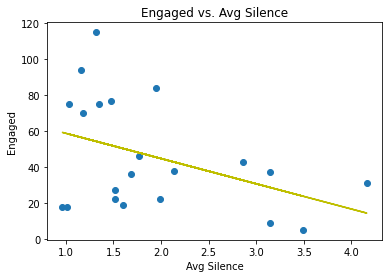

RValue: -0.413
PValue: 0.063


In [31]:
graph_dfs(values, 'Avg Silence', 'Engaged')

In the `Engaged vs. Avg Silence` graph, we see what looks like maybe three clusters forming: A cluster of high engagement and shorter periods of silence, a cluster of low engagement and short periods of silence, and a cluster of low engagement and longer periods of silence


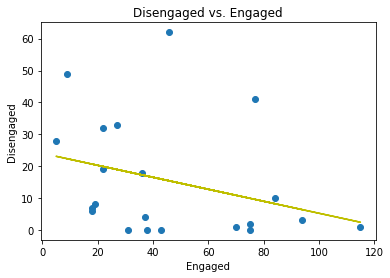

RValue: -0.315
PValue: 0.164


In [32]:
graph_dfs(values, 'Engaged', 'Disengaged')

In `Disengaged vs. Engaged`, we see what we might expect, namely that interviews with higher numbers of disengaged periods have fewer periods of engagment, and vice versa, and similarly with 'No Answers vs. Engaged'


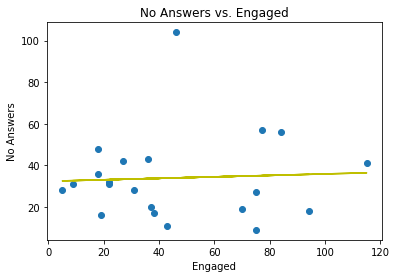

RValue: 0.051
PValue: 0.825


In [33]:
graph_dfs(values, 'Engaged', 'No Answers')

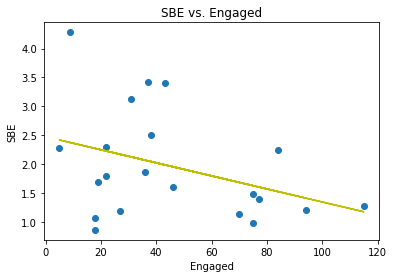

RValue: -0.372
PValue: 0.097


In [34]:
graph_dfs(values, 'Engaged', 'SBE')

In `SBE vs. Engaged`, we can see the formation of two clusters, in which interviews which have fewer engaged responses also have longer periods of silence before those responses


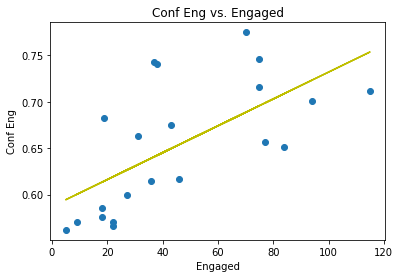

RValue: 0.645
PValue: 0.002


In [36]:
graph_dfs(values, 'Engaged', 'Conf Eng')

In `Conf Eng vs. Engaged`, we can also see that the model is generally more confident in predicting engagement in which there are more engaged responses


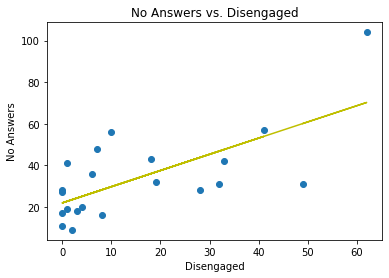

RValue: 0.680
PValue: 0.001


In [37]:
graph_dfs(values, 'Disengaged', 'No Answers')

In `No Answers vs. Disengaged`, we see that a lack of responses and the number of disengaged responses have a relatively direct relationship


These are only a few of the graphs that show interesting relationships, as many others have some semblance of cluster formation. This is promising for the idea that these structural features can be used to form a binary definition of social contingency

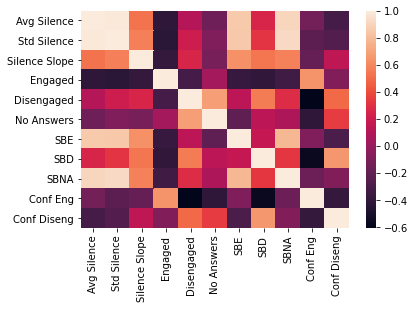

In [7]:
# Correlation matrix of the structural features 

import seaborn as sns

import matplotlib.pyplot as plt

corr_matrix = values.corr()
sns.heatmap(corr_matrix)